In [18]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [19]:
# Preprocess the images
def preprocess_image(image_path):
    try:
        image = cv2.imread(image_path)
        if image is None:
            corrupted_images.append(image_path)
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128, 128))  # Xception input size
        return image
    except Exception:
        corrupted_images.append(image_path)
        return None

# Load the dataset
def load_artist_data_as_dataframe(data_dir):
    data = []  
    label_map = {}
    corrupted_images = []

    for idx, folder in enumerate(os.listdir(data_dir)):
        if folder.startswith("pins_"):
            artist_name = folder.split('_', 1)[1]
            folder_path = os.path.join(data_dir, folder)
            num_images = len([file for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
            label_map[artist_name] = (idx, num_images)

    # Sort the label_map by the number of images and select the biggest 55 classes
    sorted_label_map = dict(sorted(label_map.items(), key=lambda item: item[1][1], reverse=True)[:55])

    # Remap the labels to be in the range 0 to 54
    new_label_map = {artist_name: new_idx for new_idx, (artist_name, _) in enumerate(sorted_label_map.items())}

    for artist_name, (old_idx, _) in sorted_label_map.items():
        folder = f"pins_{artist_name}"
        folder_path = os.path.join(data_dir, folder)
        
        for file in os.listdir(folder_path):
            if file.endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(folder_path, file)
                image = preprocess_image(file_path)
                if image is not None:
                    data.append({
                        "image_array": image,
                        "image_path": file_path,
                        "label": new_label_map[artist_name],
                        "artist_name": artist_name
                    })
    
    df = pd.DataFrame(data)
    return df, new_label_map


In [20]:
data_dir = "105_classes_pins_dataset"
df, label_map = load_artist_data_as_dataframe(data_dir)

# Train-test split
df = df.groupby('label').filter(lambda x: len(x) >= 2)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

X_train = np.stack(train_df['image_array'].values)
y_train = train_df['label'].values

X_test = np.stack(test_df['image_array'].values)
y_test = test_df['label'].values

# Normalize for Xception
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [21]:
# Training with data augmentation
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_test, y_test, batch_size=32)

In [24]:
import tensorflow as tf
from tensorflow.keras.models import load_model, predict_proba

model = load_model('xception_face_55classification_best_36.keras')

results = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', results[0])
print('Test accuracy:', results[1])


Test loss: 3.718925952911377
Test accuracy: 0.3464788794517517


In [25]:
results = model.evaluate(X_test, y_test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])


67/67 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.3556 - loss: 3.6731
Test loss: 3.718925952911377
Test accuracy: 0.3464788794517517


In [74]:
train_loss12, train_accuracy12 = model.evaluate(X_train, y_train)
print(f"Loss: {train_loss12}, Accuracy: {train_accuracy12 * 100}%")

267/267 ━━━━━━━━━━━━━━━━━━━━ 748s 3s/step - accuracy: 0.3335 - loss: 3.7479
Loss: 3.7543065547943115, Accuracy: 33.204224705696106%


In [26]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

67/67 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step
Accuracy: 0.3464788732394366


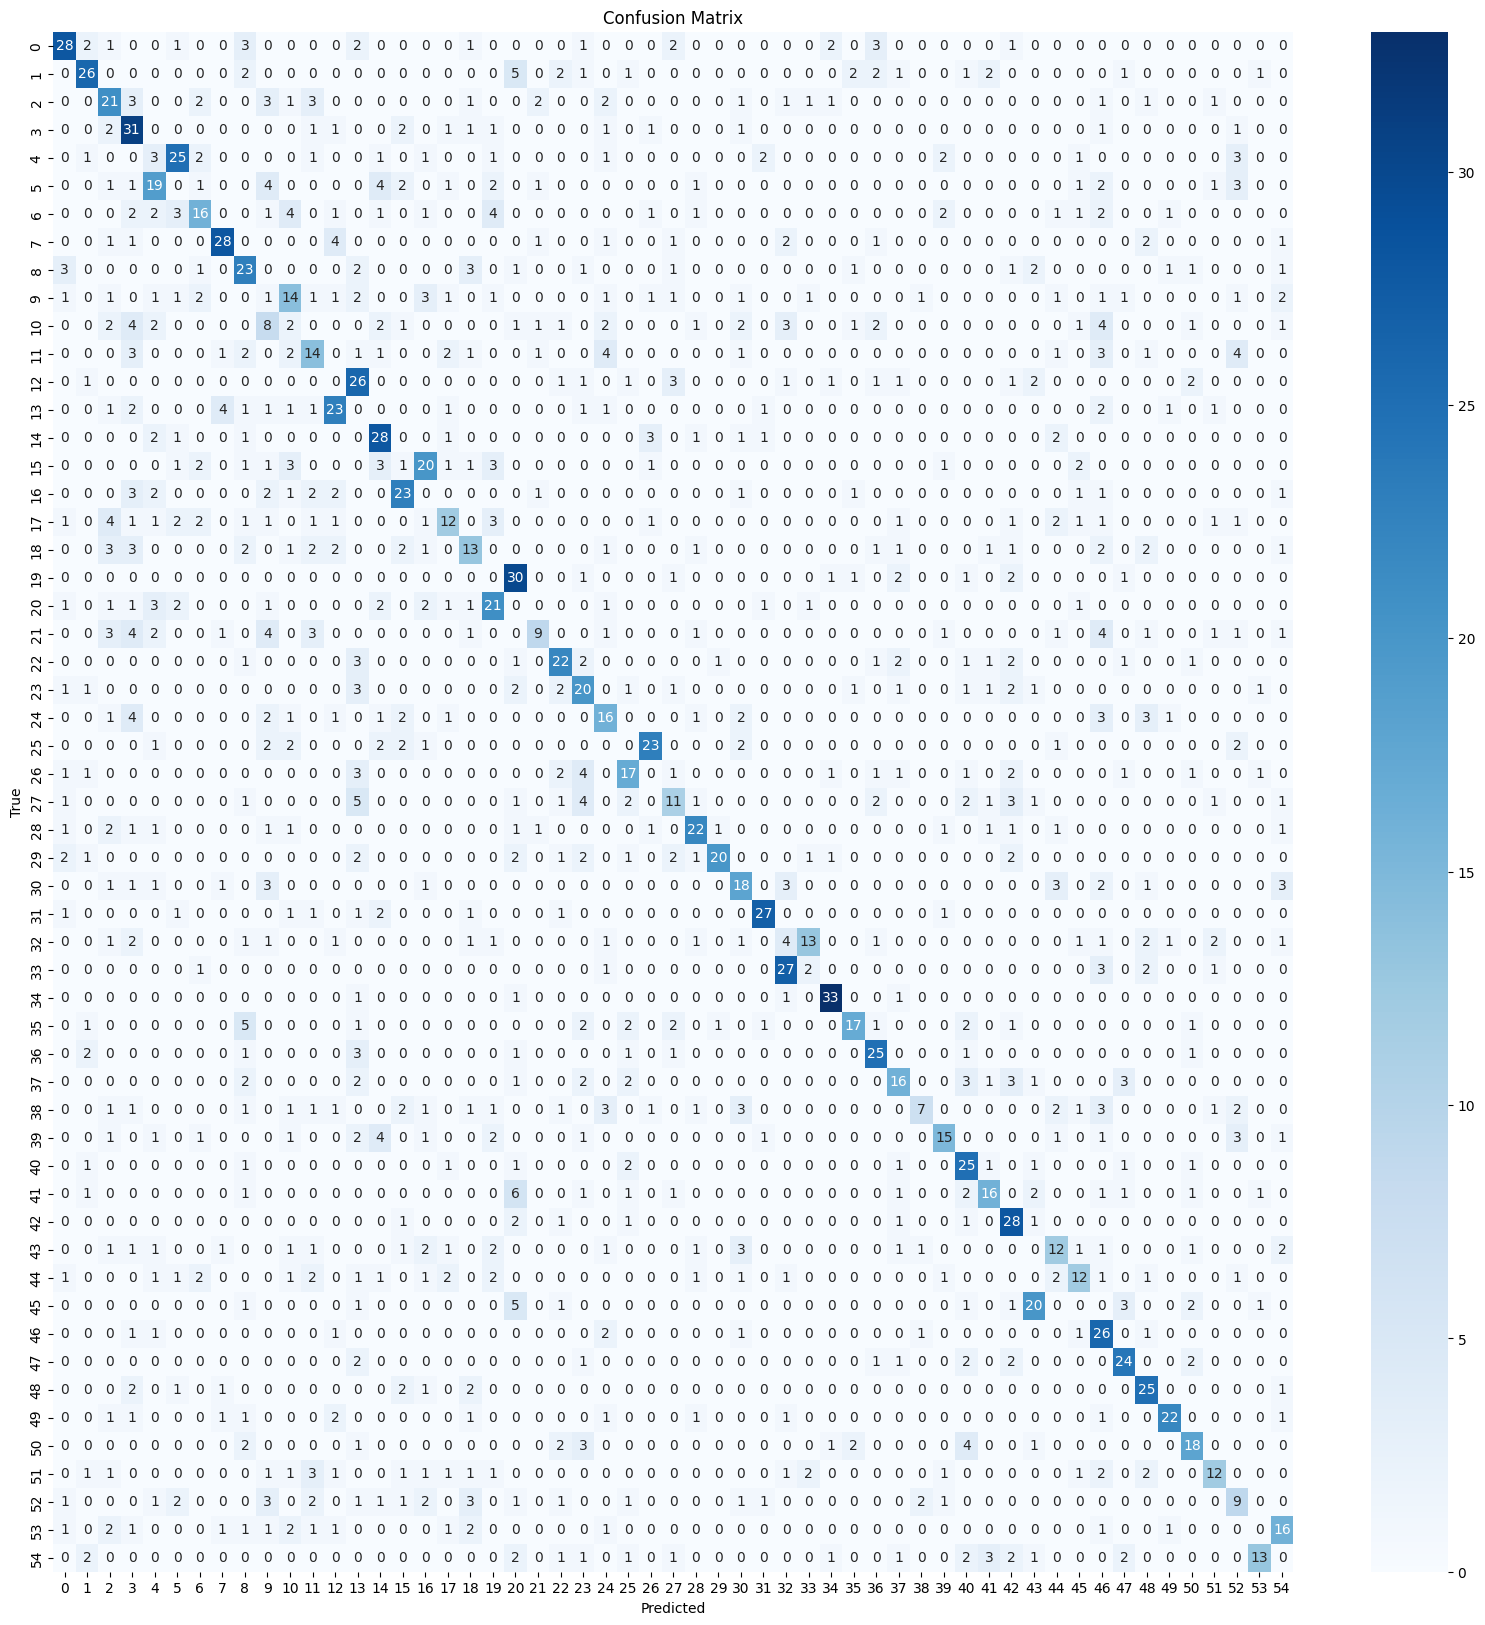

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

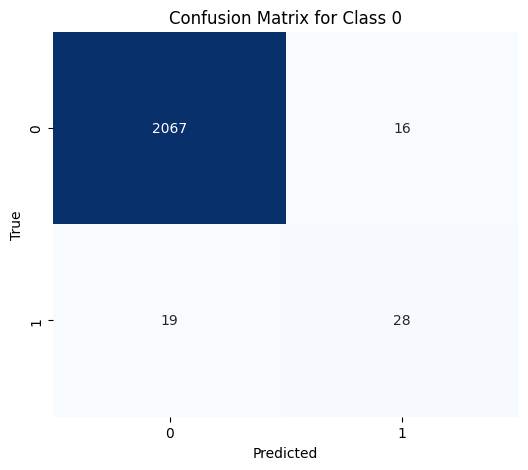

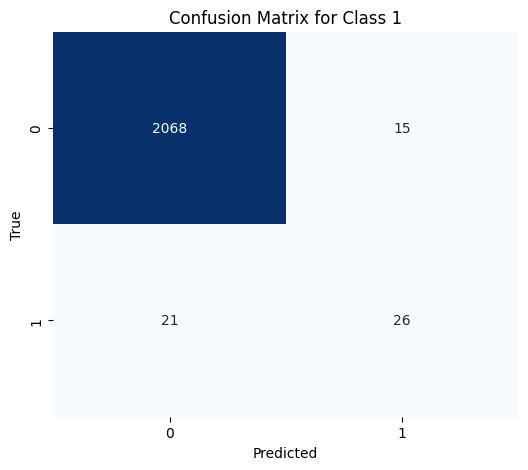

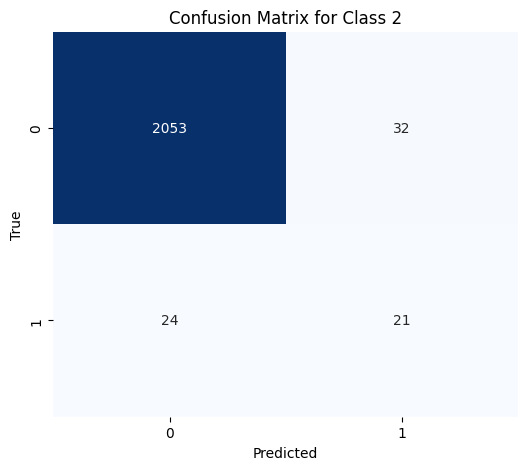

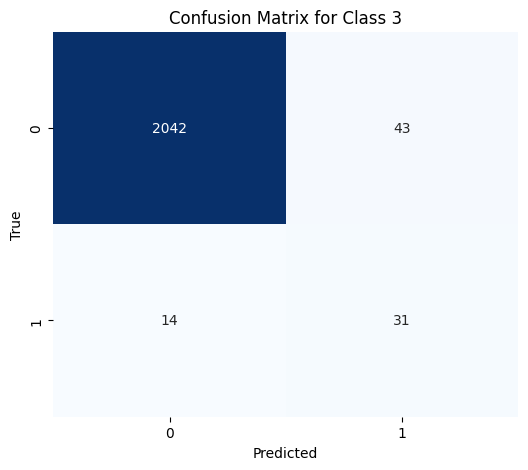

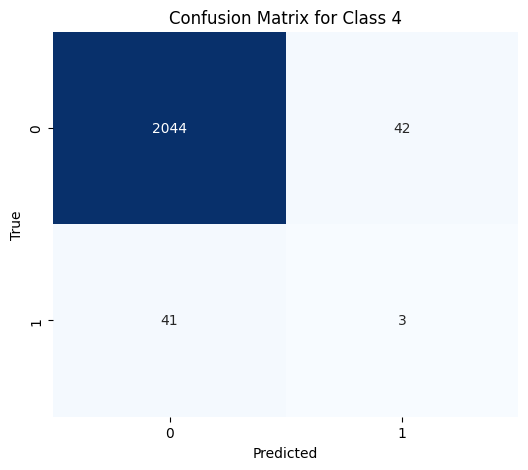

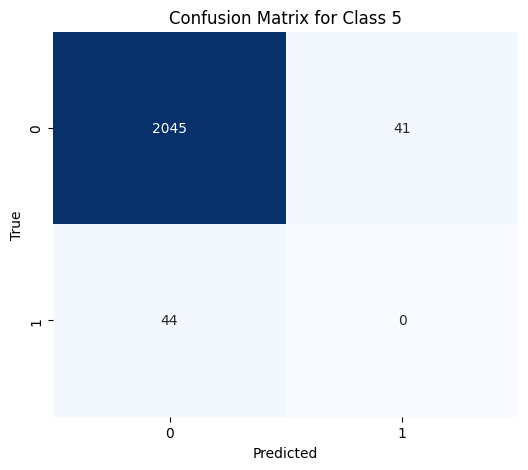

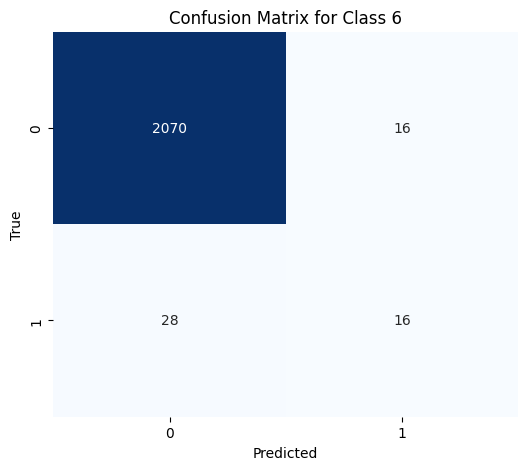

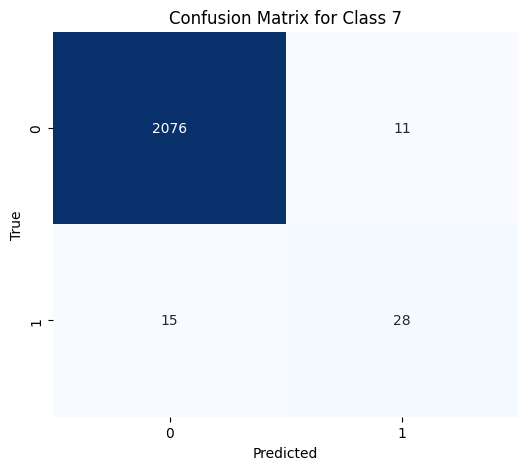

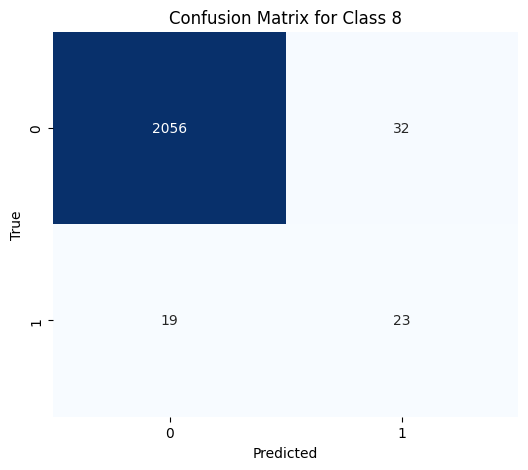

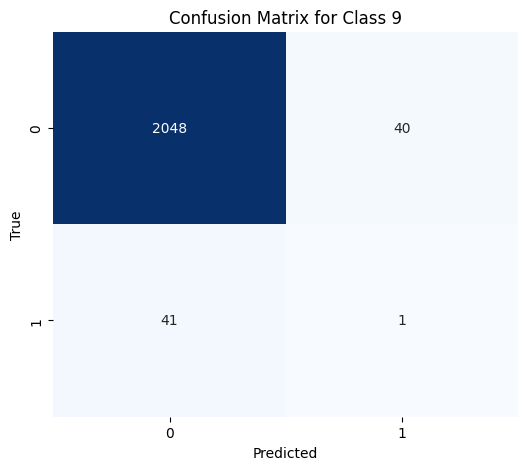

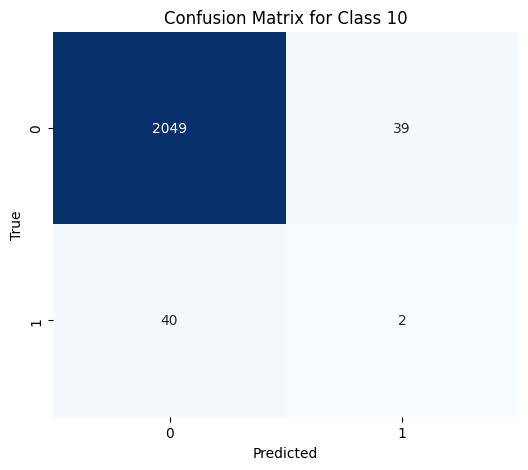

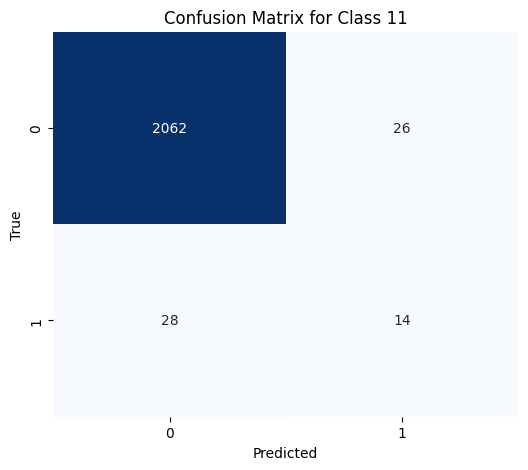

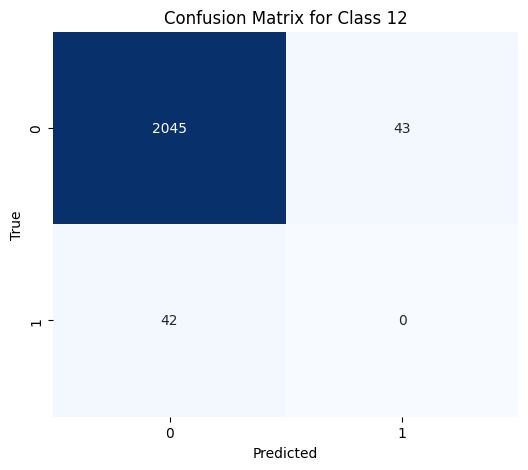

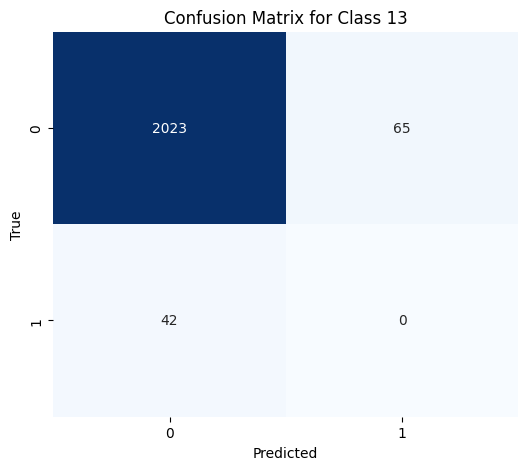

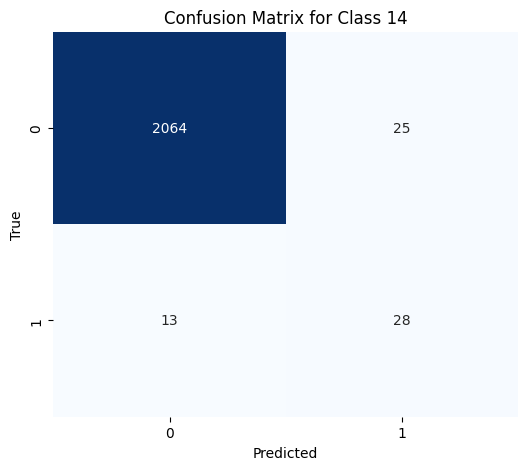

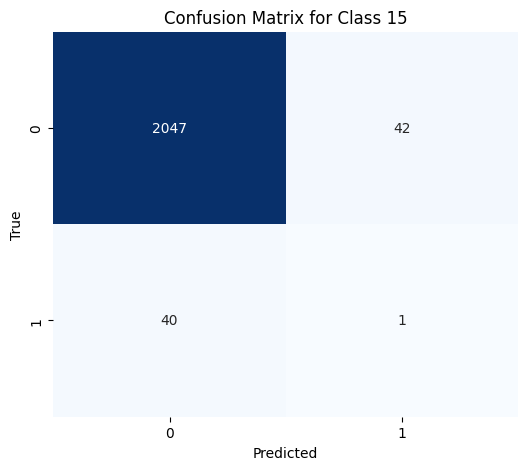

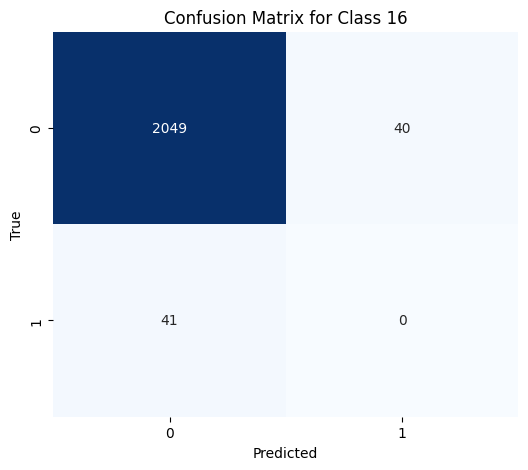

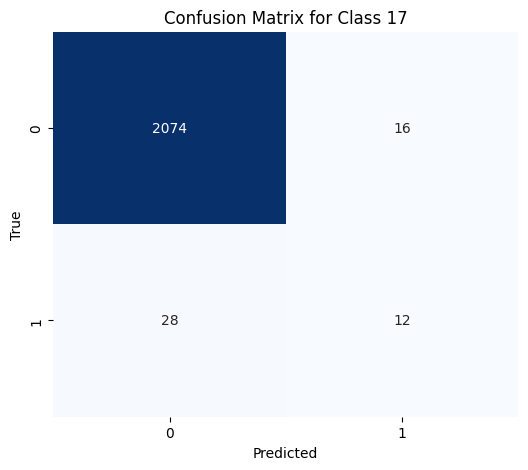

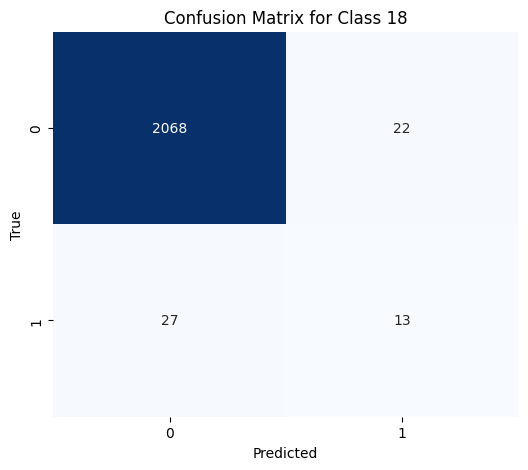

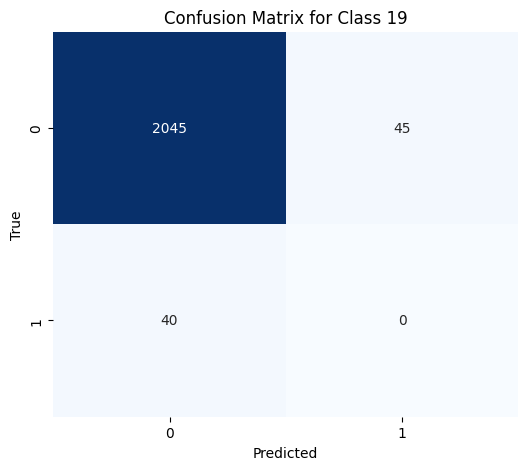

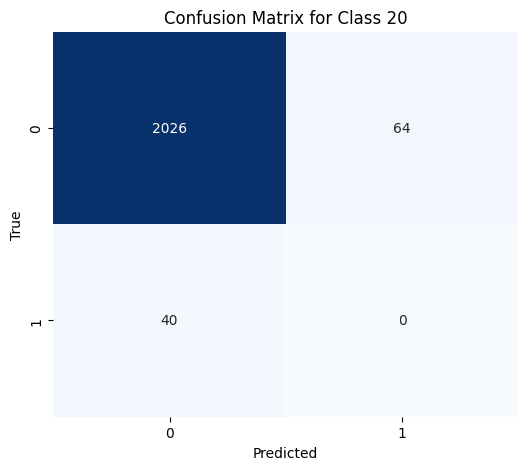

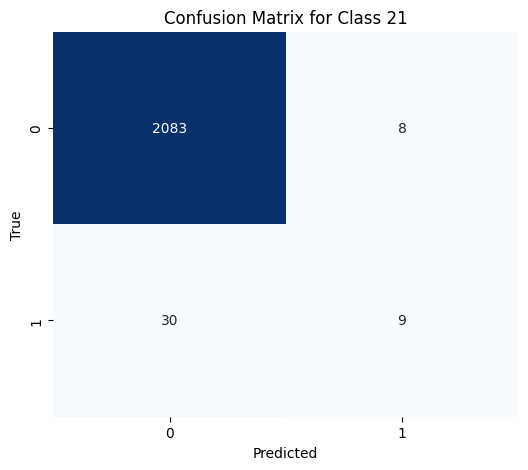

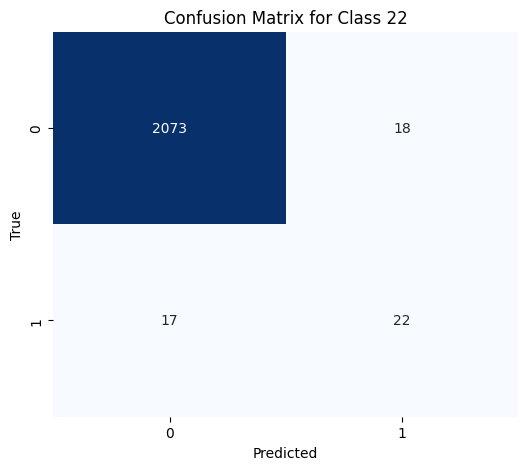

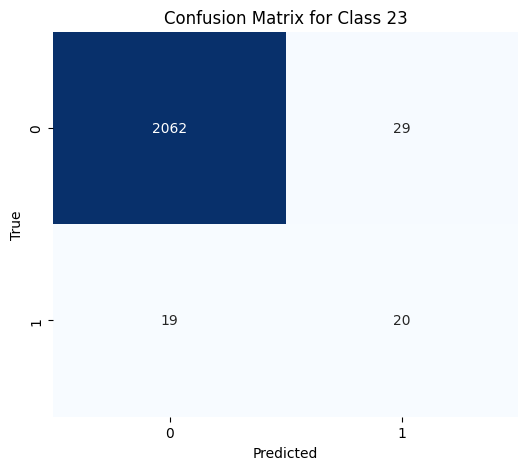

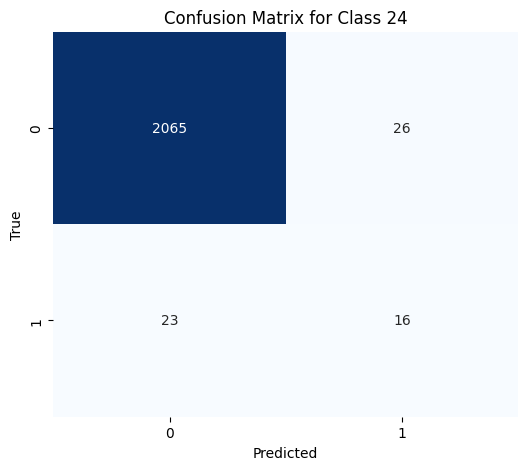

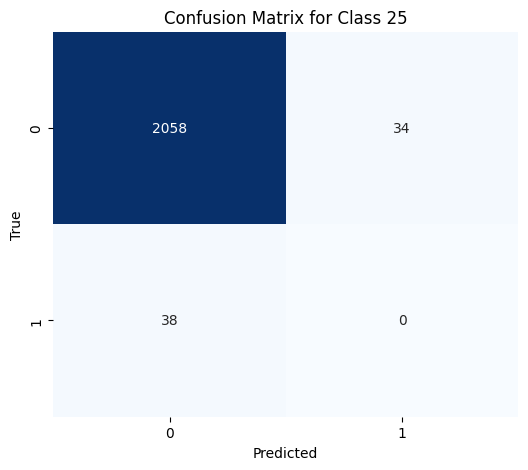

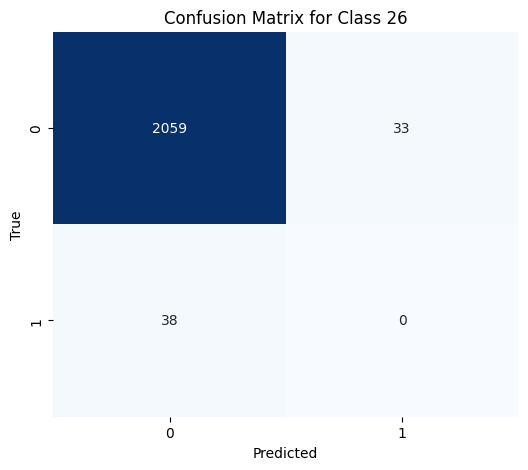

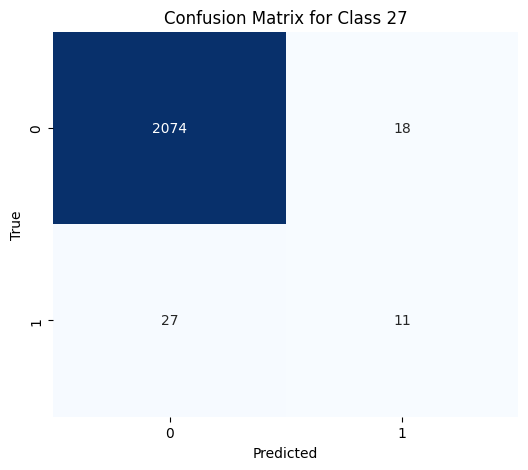

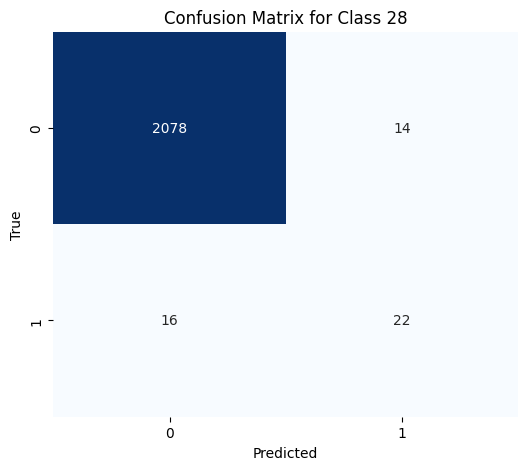

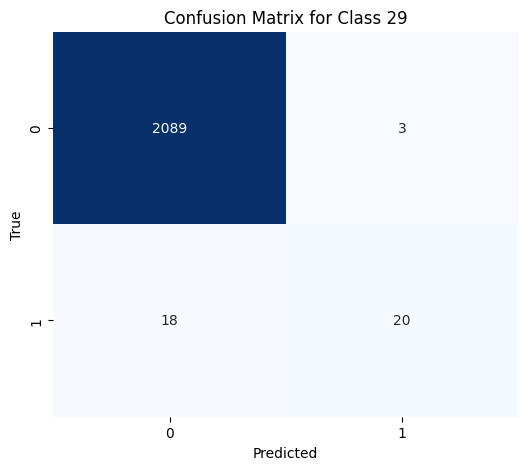

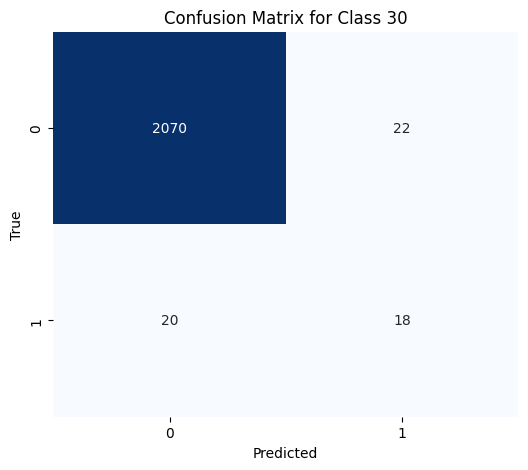

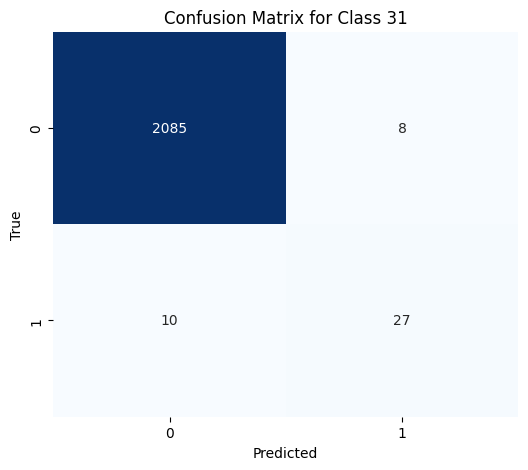

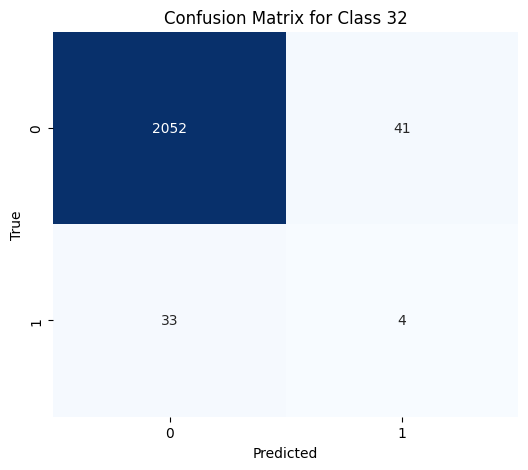

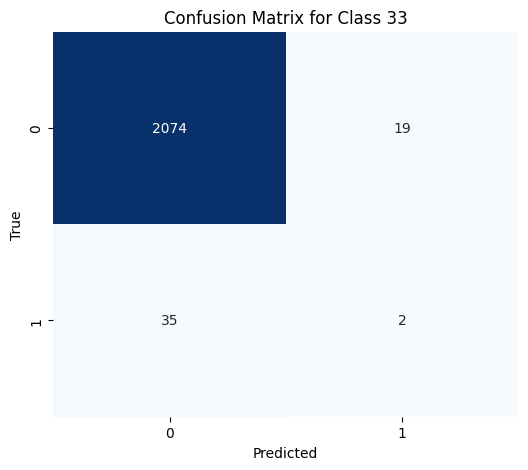

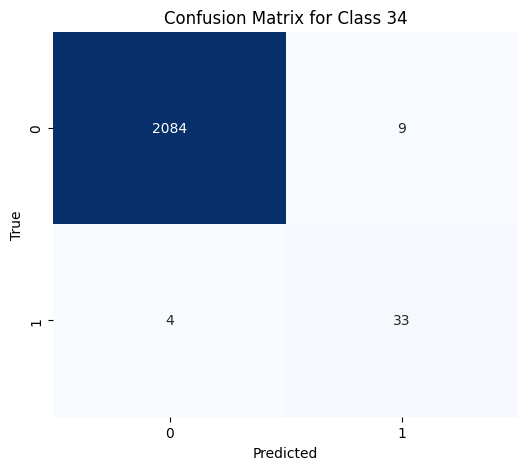

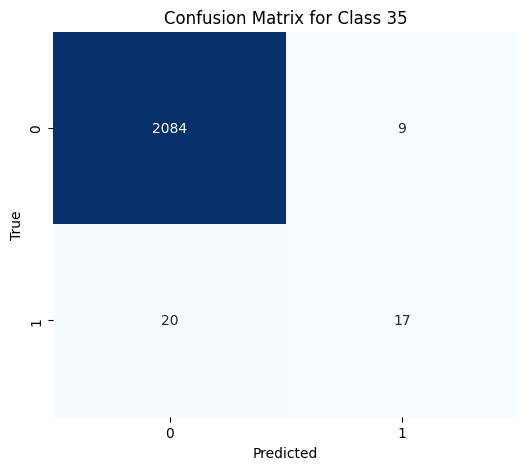

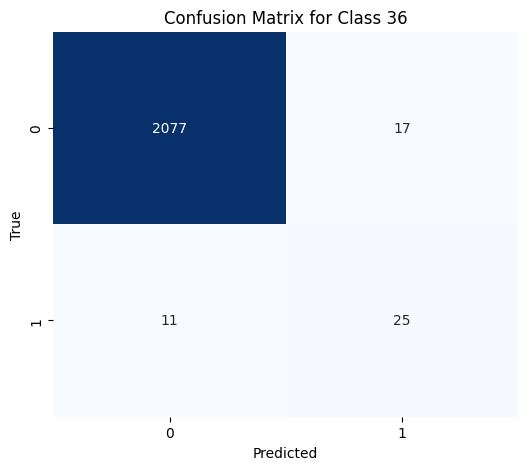

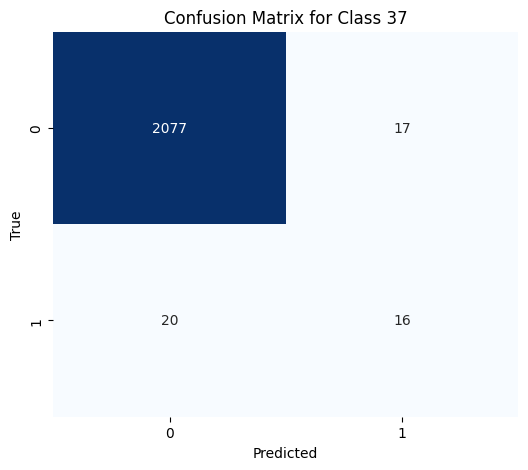

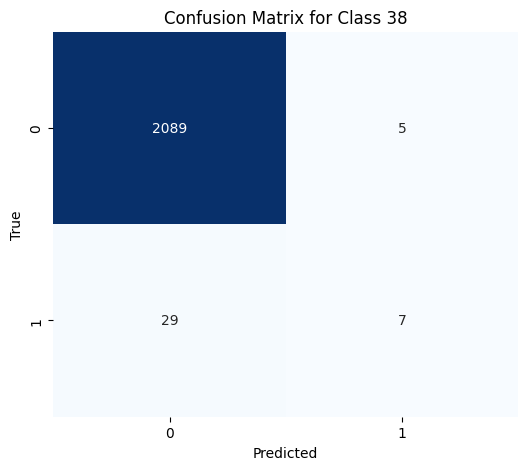

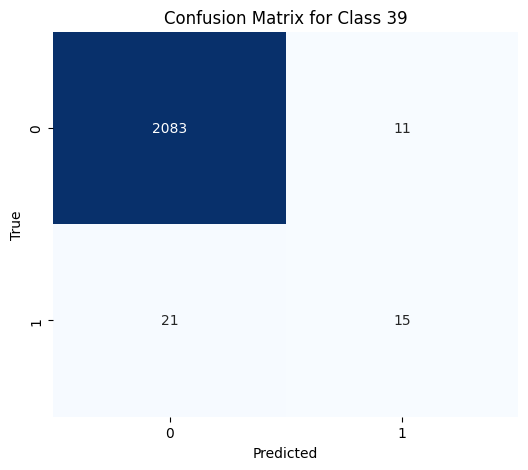

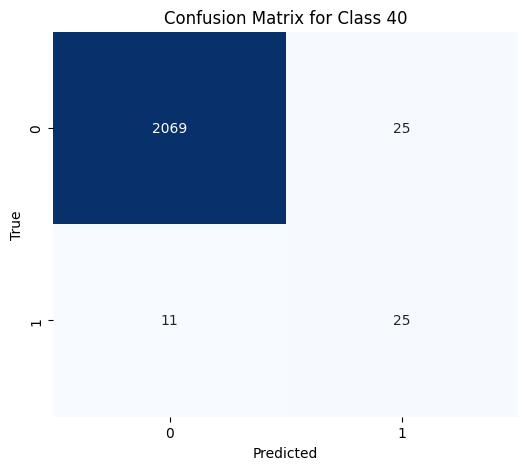

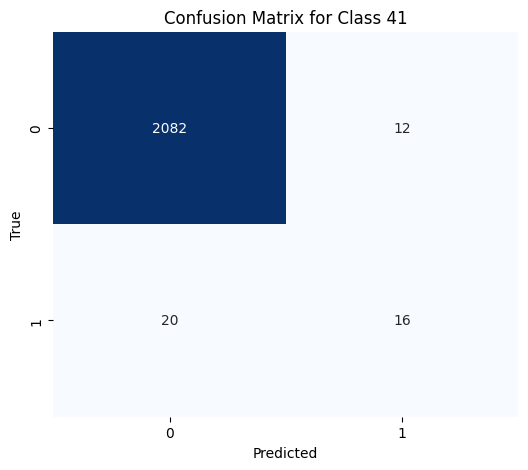

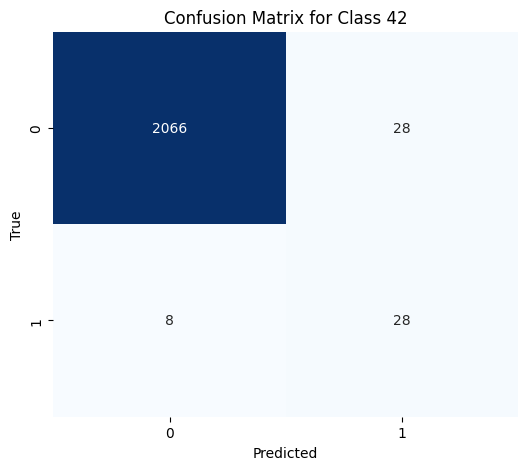

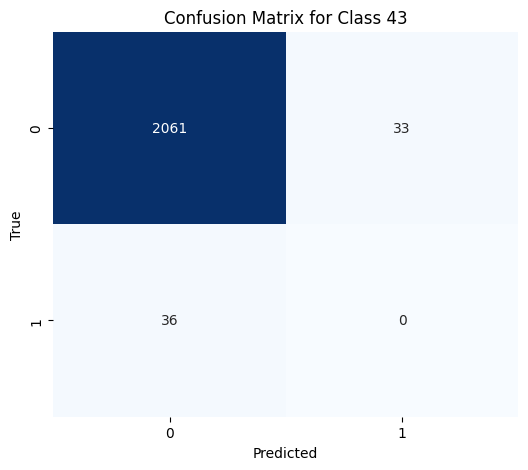

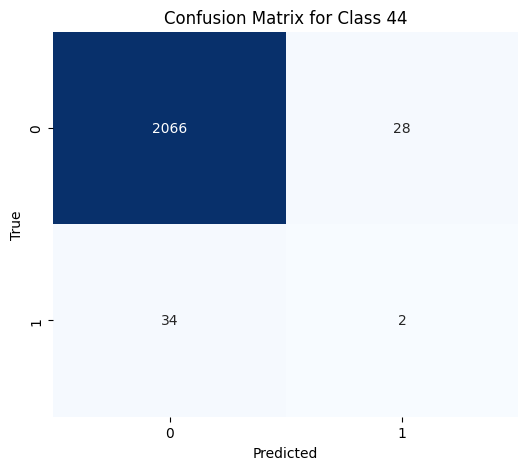

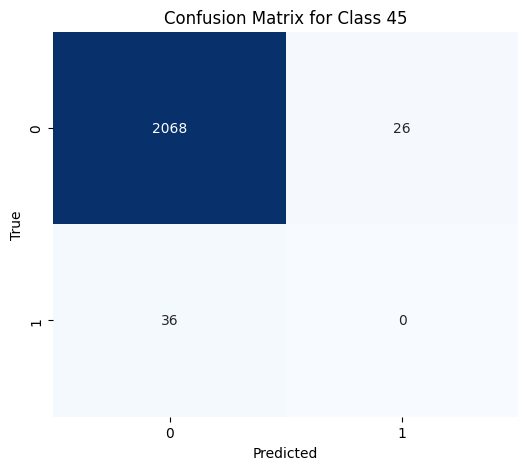

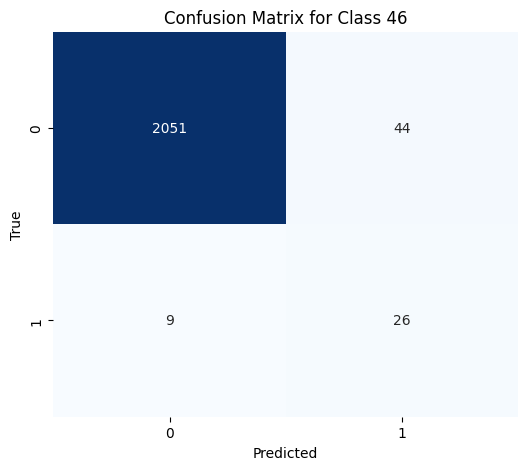

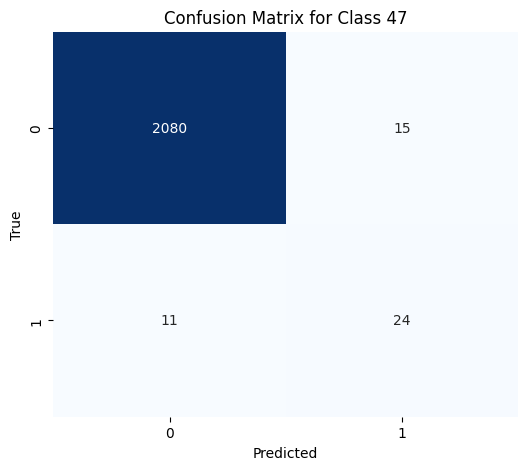

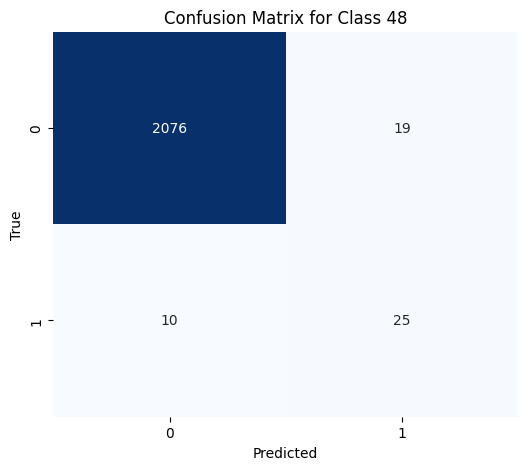

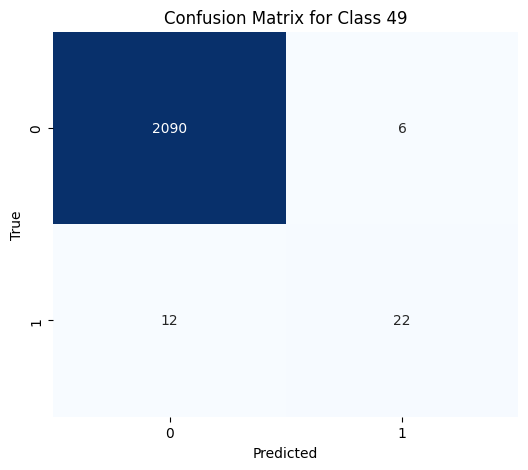

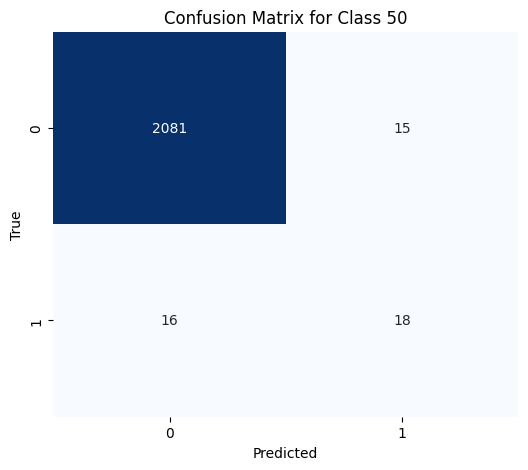

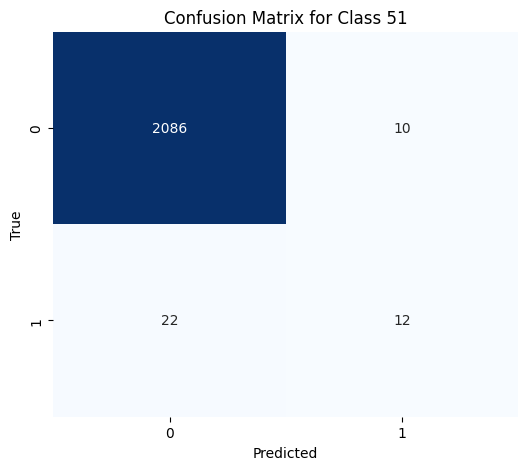

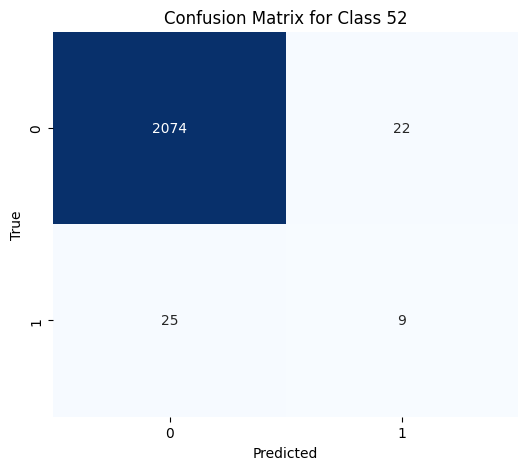

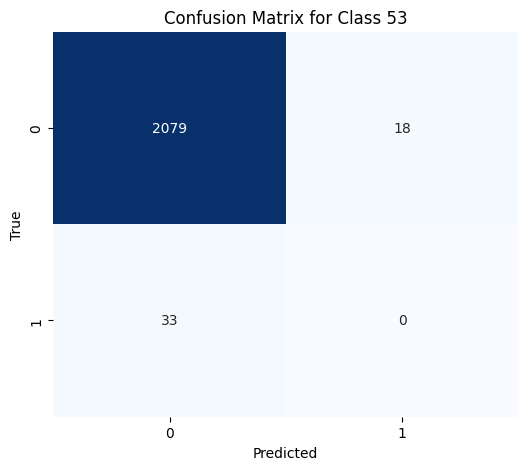

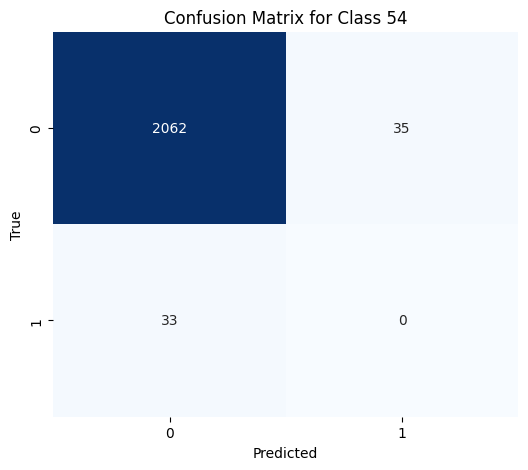

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# List of classes
classes = np.unique(y_test)

# Loop through each class and plot a binary confusion matrix
for class_idx, class_label in enumerate(classes):
    # Binarize the true and predicted labels for the current class
    y_test_binary = (y_test == class_label).astype(int)
    y_pred_binary = (y_pred_classes == class_label).astype(int)
    
    # Compute confusion matrix for the current class
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Class {class_label}')
    plt.show()


In [40]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.60      0.62        47
           1       0.63      0.55      0.59        47
           2       0.40      0.47      0.43        45
           3       0.42      0.69      0.52        45
           4       0.07      0.07      0.07        44
           5       0.00      0.00      0.00        44
           6       0.50      0.36      0.42        44
           7       0.72      0.65      0.68        43
           8       0.42      0.55      0.47        42
           9       0.02      0.02      0.02        42
          10       0.05      0.05      0.05        42
          11       0.35      0.33      0.34        42
          12       0.00      0.00      0.00        42
          13       0.00      0.00      0.00        42
          14       0.53      0.68      0.60        41
          15       0.02      0.02      0.02        41
          16       0.00      0.00      0.00        41
          17       0.43    

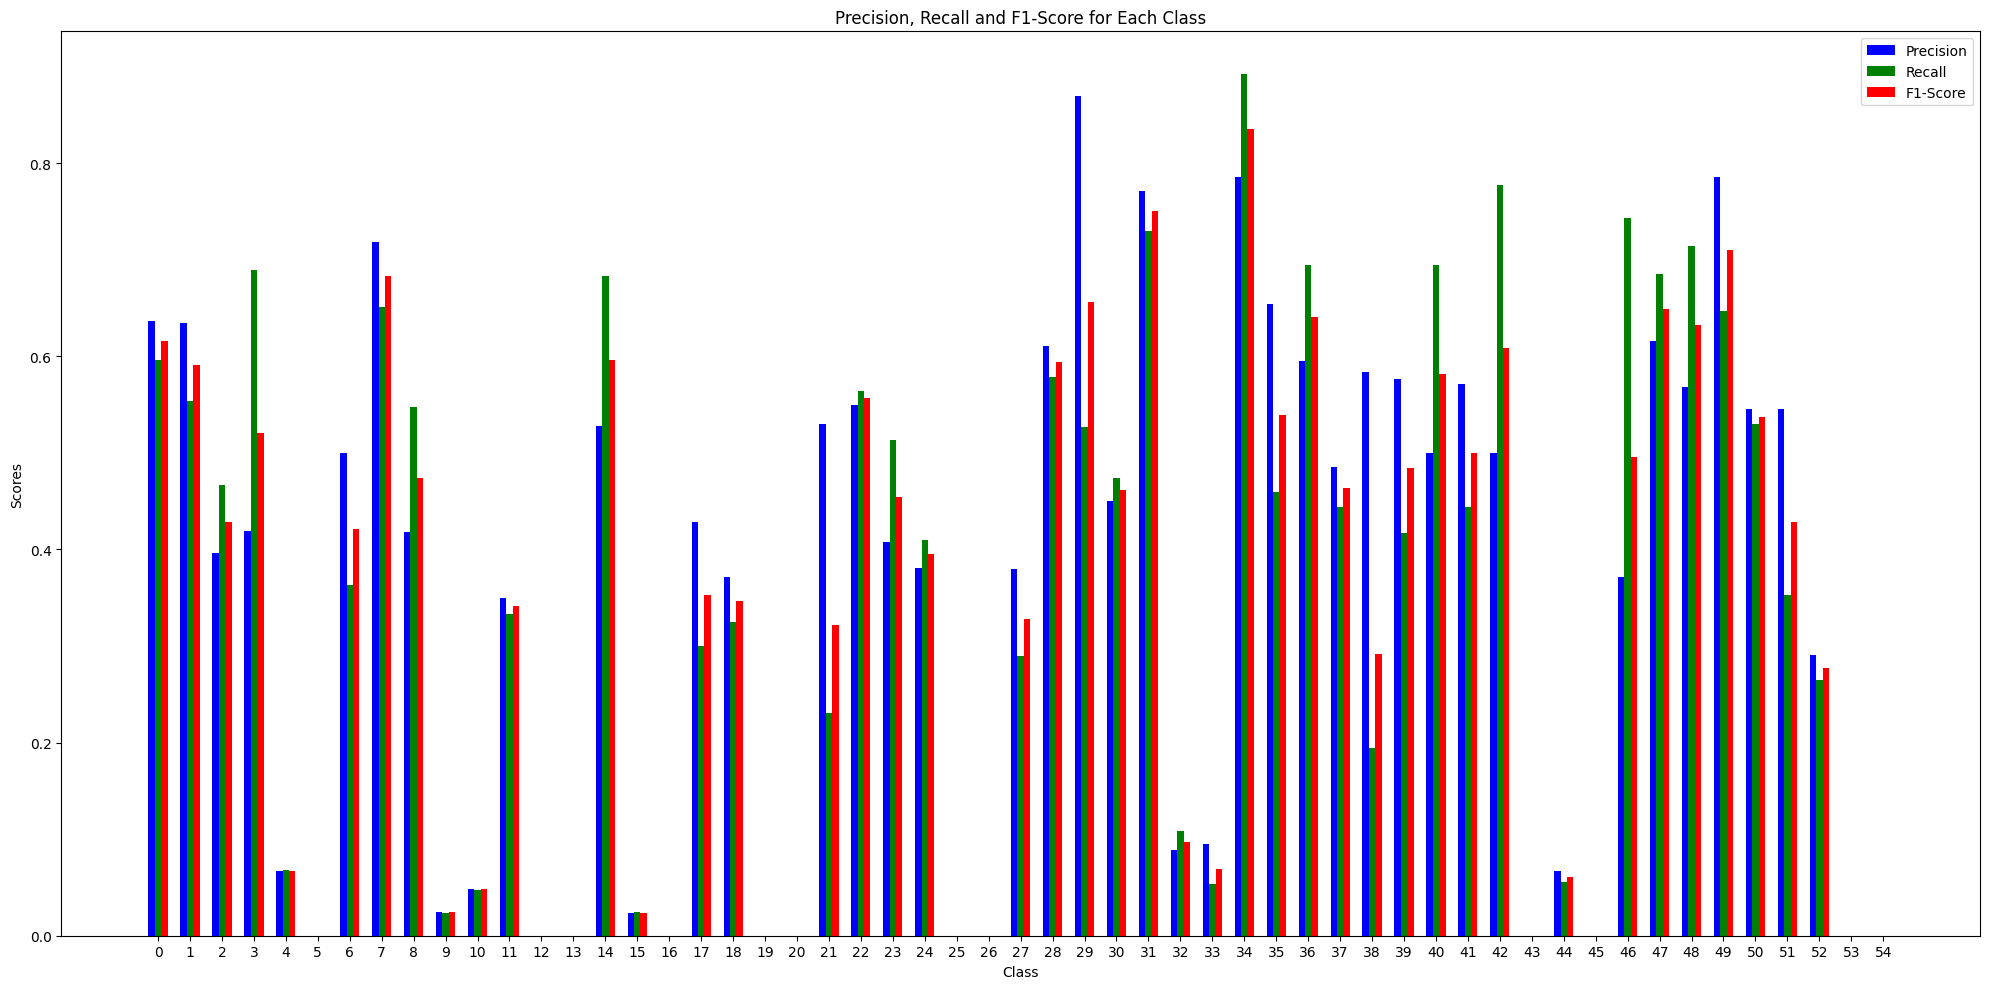

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Assuming y_test are true labels and y_pred_classes are predicted labels
report = classification_report(y_test, y_pred_classes, output_dict=True)

# Extracting metrics for each class
classes = list(report.keys())[:-3]  # Exclude accuracy, macro avg, and weighted avg
precision = [report[class_name]['precision'] for class_name in classes]
recall = [report[class_name]['recall'] for class_name in classes]
f1_score = [report[class_name]['f1-score'] for class_name in classes]

# Plotting the metrics
x = np.arange(len(classes))

fig, ax = plt.subplots(figsize=(20, 10))
width = 0.2  # Bar width
ax.bar(x - width, precision, width, label='Precision', color='b')
ax.bar(x, recall, width, label='Recall', color='g')
ax.bar(x + width, f1_score, width, label='F1-Score', color='r')

# Adding labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1-Score for Each Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.tight_layout()
plt.show()


67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step


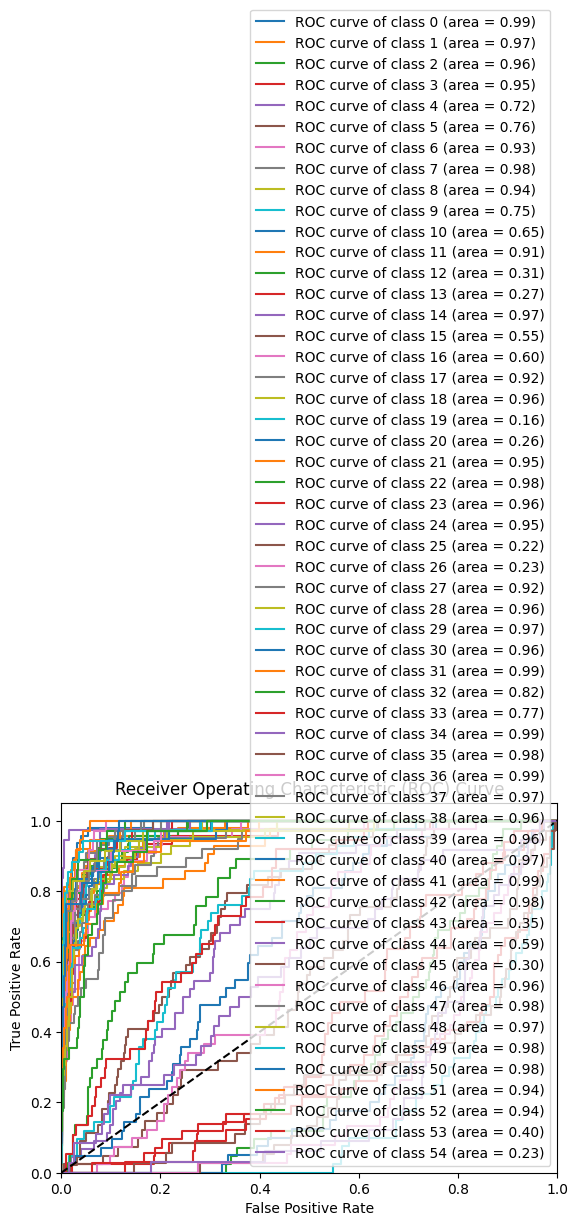

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))

# Get class probabilities
y_pred_prob = model.predict(X_test)  # Assuming softmax output layer
# Or, if necessary:
# y_pred_prob = softmax(model.predict(X_test), axis=1)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

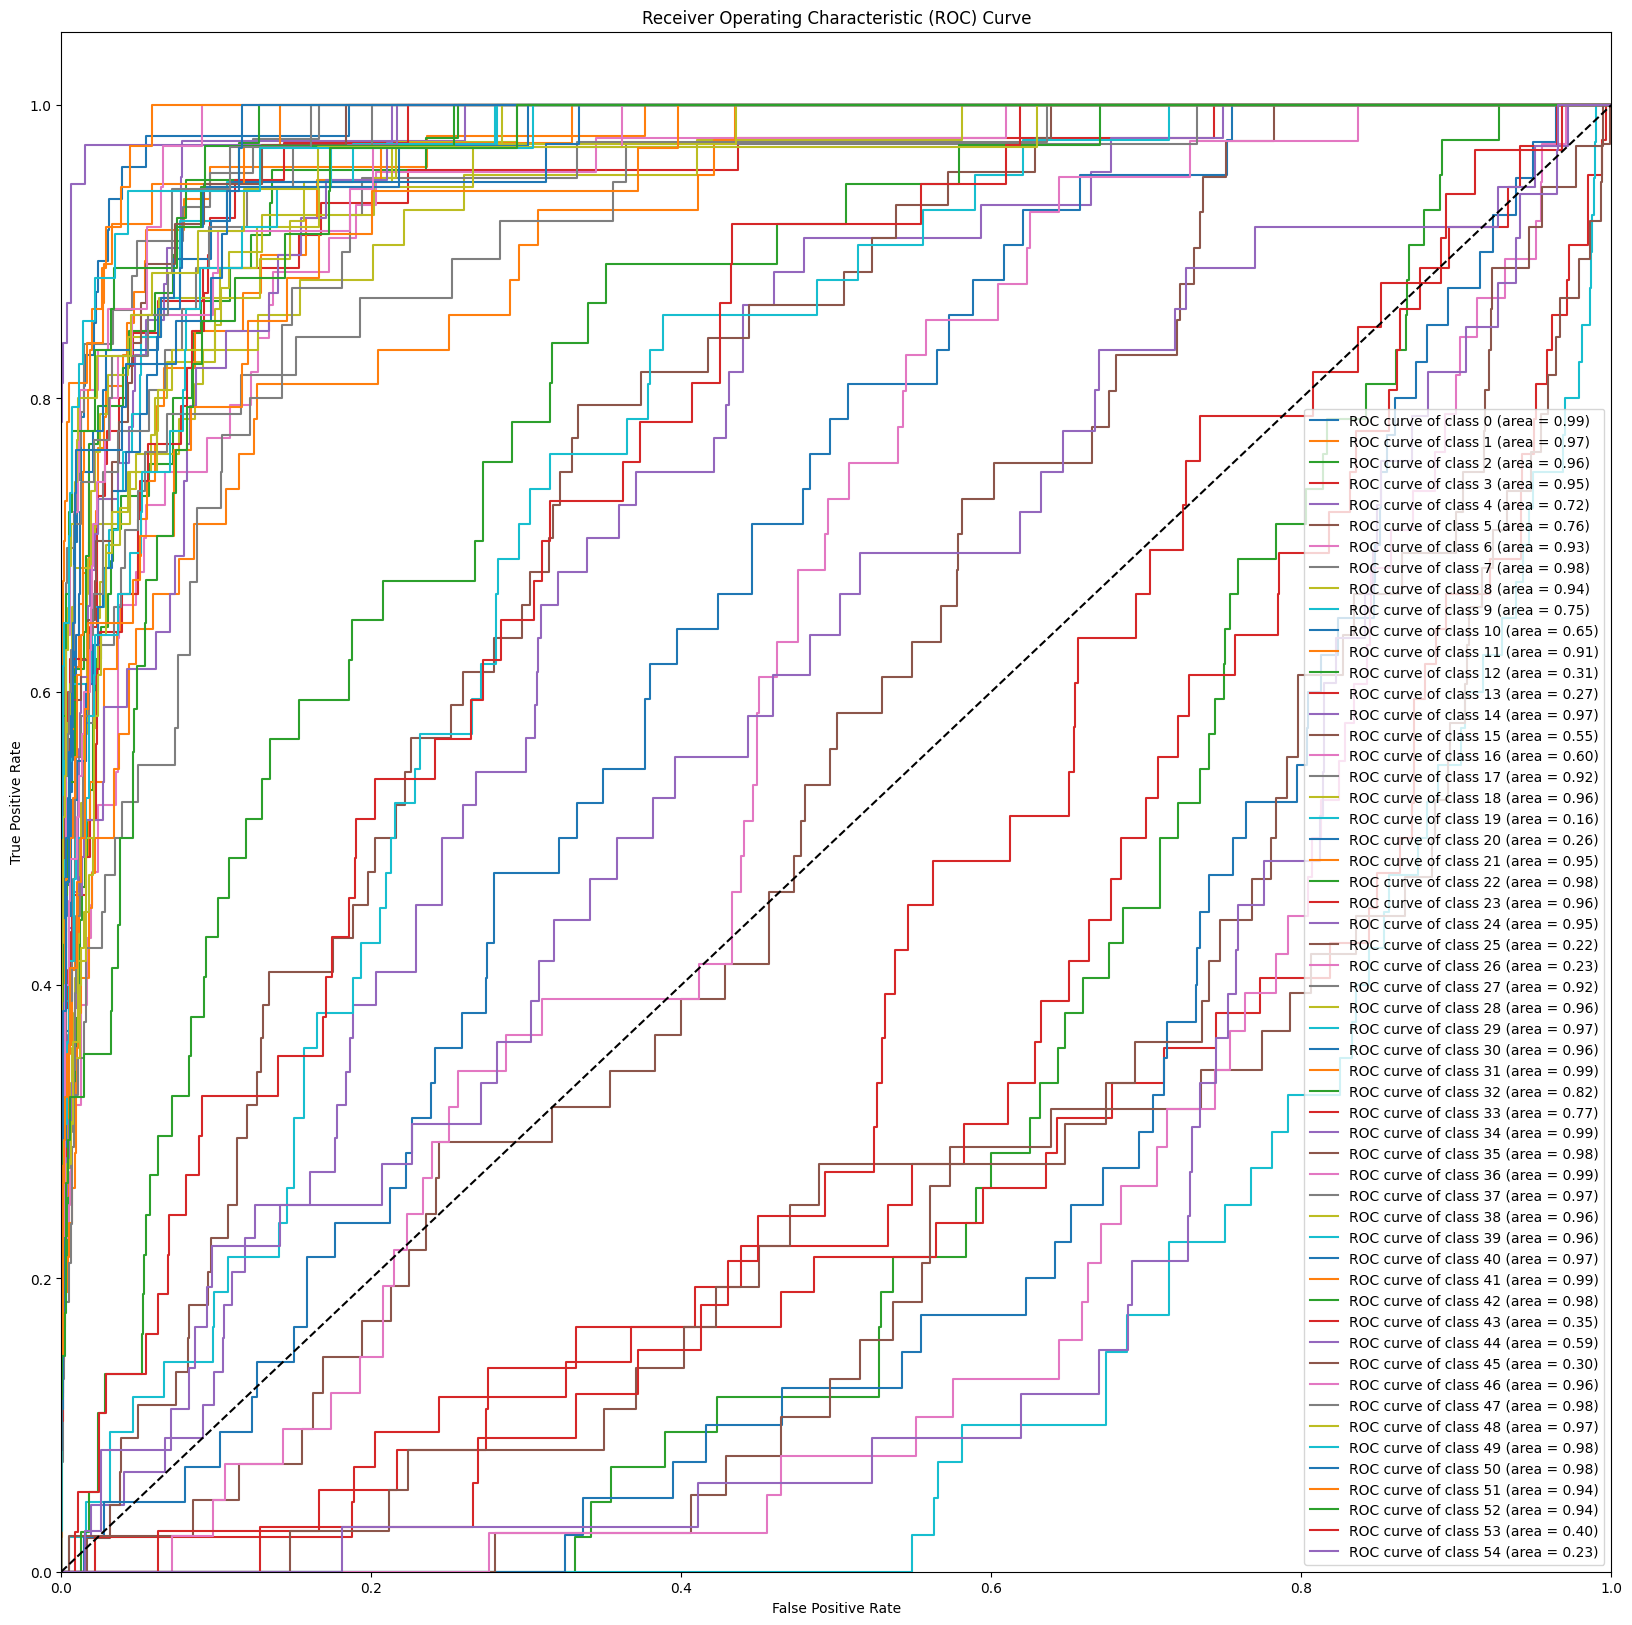

In [58]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))
#y_pred_prob = model.predict(X_test)  # Assuming softmax output layer

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(20,20))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print AUC values
print("AUC values for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.2f}")


AUC values for each class:
Class 0: 0.99
Class 1: 0.97
Class 2: 0.96
Class 3: 0.95
Class 4: 0.72
Class 5: 0.76
Class 6: 0.93
Class 7: 0.98
Class 8: 0.94
Class 9: 0.75
Class 10: 0.65
Class 11: 0.91
Class 12: 0.31
Class 13: 0.27
Class 14: 0.97
Class 15: 0.55
Class 16: 0.60
Class 17: 0.92
Class 18: 0.96
Class 19: 0.16
Class 20: 0.26
Class 21: 0.95
Class 22: 0.98
Class 23: 0.96
Class 24: 0.95
Class 25: 0.22
Class 26: 0.23
Class 27: 0.92
Class 28: 0.96
Class 29: 0.97
Class 30: 0.96
Class 31: 0.99
Class 32: 0.82
Class 33: 0.77
Class 34: 0.99
Class 35: 0.98
Class 36: 0.99
Class 37: 0.97
Class 38: 0.96
Class 39: 0.96
Class 40: 0.97
Class 41: 0.99
Class 42: 0.98
Class 43: 0.35
Class 44: 0.59
Class 45: 0.30
Class 46: 0.96
Class 47: 0.98
Class 48: 0.97
Class 49: 0.98
Class 50: 0.98
Class 51: 0.94
Class 52: 0.94
Class 53: 0.40
Class 54: 0.23


In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming multi-class classification
y_test_one_hot = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob = model.predict(X_test)  # Assuming softmax output layer

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_one_hot.shape[1]

# Calculate ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])



67/67 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step


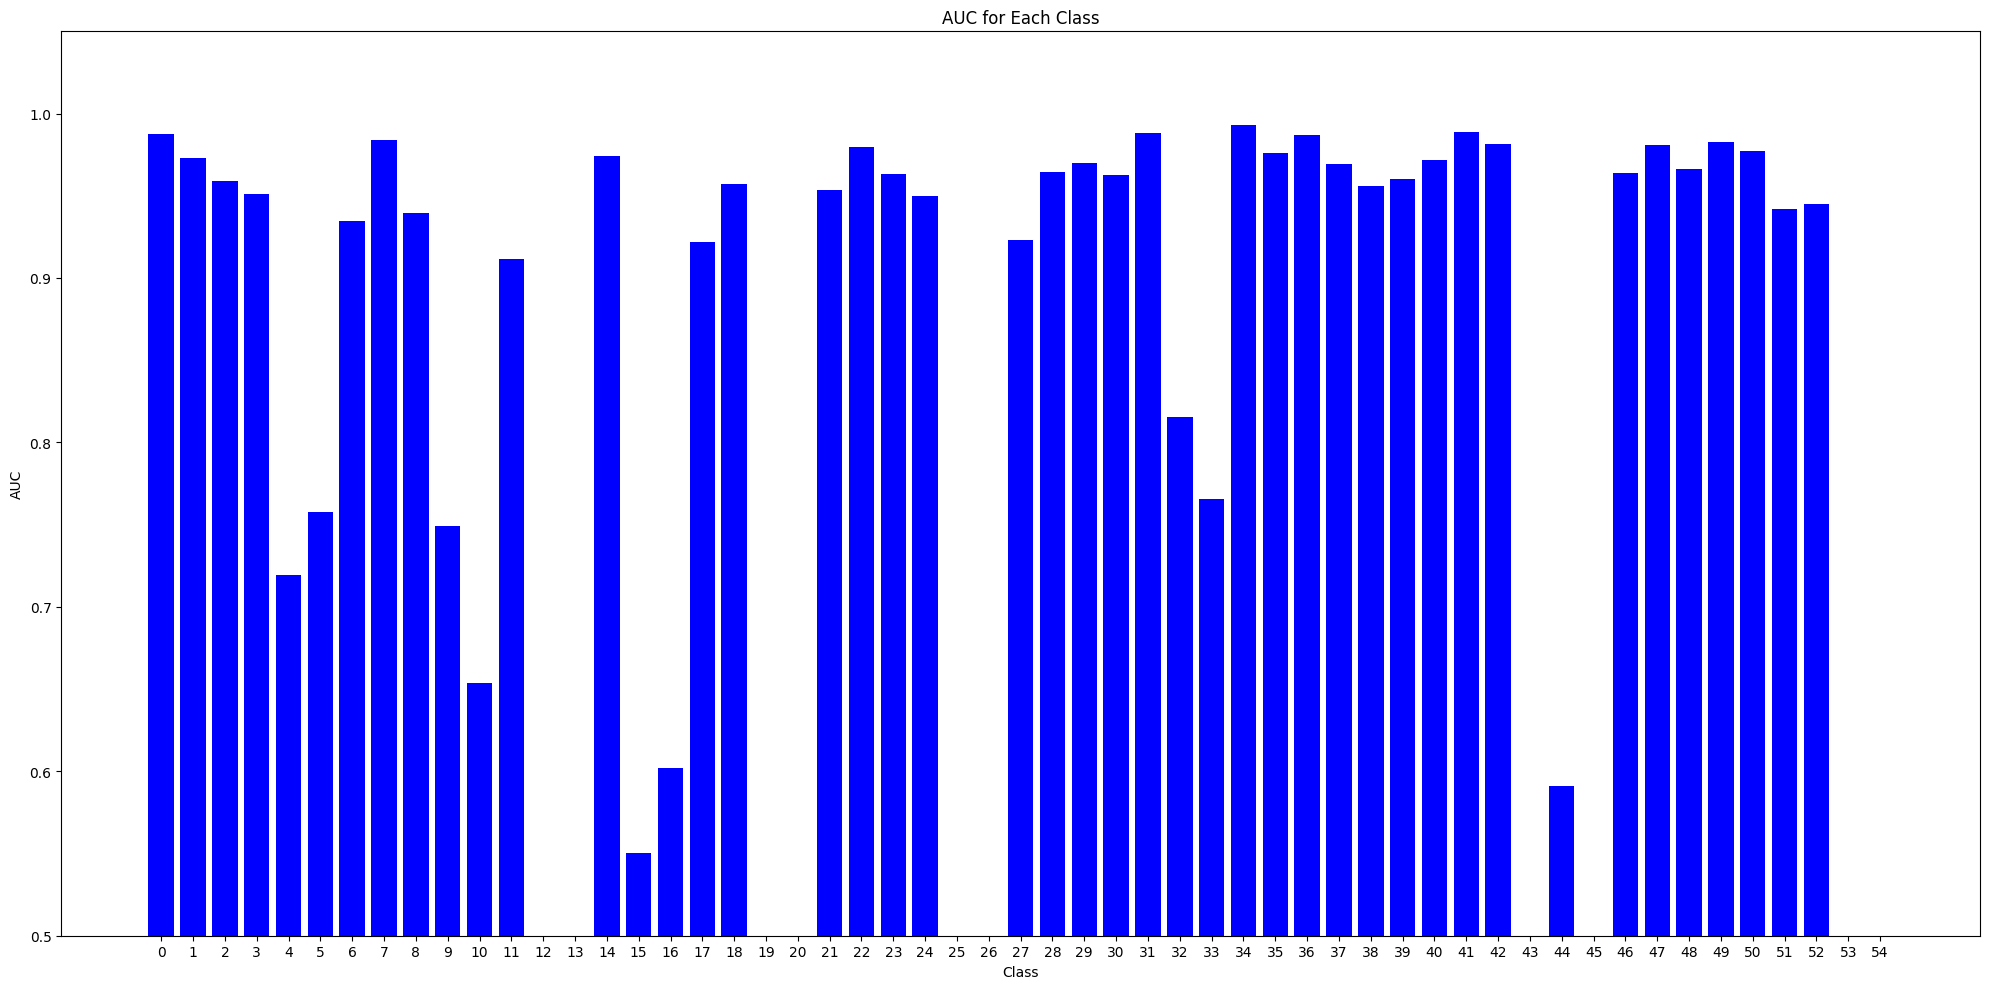

In [72]:
# Plot AUC values for each class as a bar chart
classes = [f"{i}" for i in range(n_classes)]
auc_values = [roc_auc[i] for i in range(n_classes)]

# Plotting the AUC values as a bar chart
plt.figure(figsize=(20, 10))
plt.bar(classes, auc_values, color='blue')
plt.xlabel('Class')
plt.ylabel('AUC')
plt.title('AUC for Each Class')
plt.ylim([0.5, 1.05])  # AUC ranges from 0.5 to 1
plt.tight_layout()
plt.show()

In [77]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 63, 63,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 63, 63,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 63, 63,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 61, 61,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 61, 61,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 61, 61,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 61, 61,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 61, 61,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 61, 61,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 61, 61,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 61, 61,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 31,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 31, 31,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 31, 31,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 31, 31,    │          0 │ add_12[0][0]    

 Total params: 24,093,391 (91.91 MB)

 Trainable params: 1,077,303 (4.11 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

 Optimizer params: 2,154,608 (8.22 MB)